In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from src.image_generation import moffat, sersic
from src.analysis import gaussian_weight, wiener_deconvolution, calculate_gaap_flux
import matplotlib as mpl
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [38]:
# Set plot parameters
mpl.rcParams['image.cmap'] = 'grey'
mpl.rcParams['image.origin'] = 'lower'

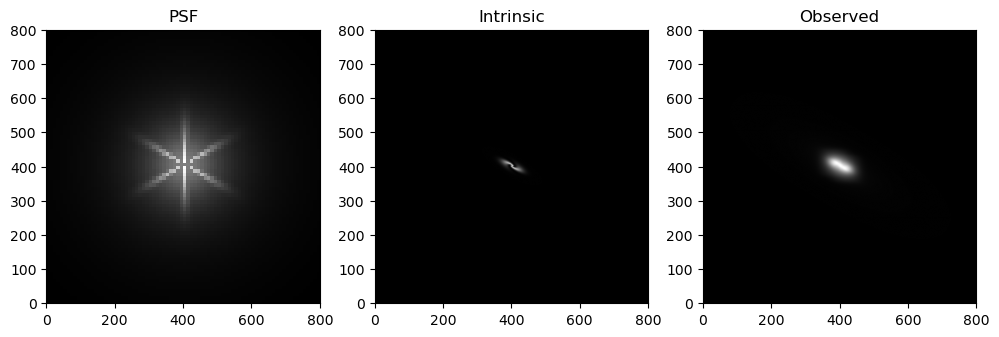

In [54]:
width = 800
height = 800

# Create PSF and Galaxy images
image_psf = moffat(width//10, height//10, 1, 10, n_spikes=3, Rc=10.0, spike_strength=1.0, spike_width=.1)
image_intrinsic = sersic(width, height, height / 2, width / 2, k=1.5, n=4, inclination=np.radians(70),
                         rotation=np.radians(30), n_arms=2, bulge_strength=1, Rc=30)

# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf, extent=(0, width, 0, height))
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic")
axs[2].imshow(image, extent=(0, width, 0, height))
axs[2].set_title("Observed")
plt.show()

In [55]:
# Define weight function
weight = gaussian_weight(height, width, height / 2, width / 2, 20, 20)
weight_low_res = gaussian_weight(height//2, width//2, height / 4, width / 4, 10, 10)

# Calculate the aperture flux using the intrinsic image and weight function
true_F = np.sum(weight * image_intrinsic)
print(f'The aperture flux measured using the intrinsic image and weight function : {true_F:.6f}')

# Calculate the aperture flux using the observed image and rescaled weight function
measured_F, sigma_F = calculate_gaap_flux(image, image_psf, weight, [(height / 2, width / 2)])
print(f'The aperture flux using the observed image and rescaled weight function : {measured_F[0]:.6f}')

The aperture flux measured using the intrinsic image and weight function : 0.252185
Deconvolving weight function
The aperture flux using the observed image and rescaled weight function : 0.252185


In [4]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift

def estimate_sigma(noise_image, weight, maxlag):
    local_covariance = covariance_fft2d(noise_image, maxlag)
    variance = weighted_variance_lag(weight, local_covariance, maxlag)
    return np.sqrt(variance)

def covariance_fft2d(image, maxlag):
    """
    Compute 2D covariance by FFT of background-subtracted residual.
    - image: 2D array (float)
    - maxlag: integer; returns covariance for lags -maxlag..+maxlag in both axes
    Returns: cov (2*maxlag+1, 2*maxlag+1) centered at lag (0,0)
    """
    img = image.astype(float)
    h, w = img.shape
    img -= np.mean(img)
    
    ac = fftconvolve(img, img[::-1, ::-1], mode="same")

    ac_norm = ac / (h * w)

    cy, cx = h//2, w//2
    window = ac_norm[cy-maxlag:cy+maxlag+1, cx-maxlag:cx+maxlag+1]
    return window



def weighted_variance_lag(s, C_local, max_lag):
    H, W = s.shape
    V = 0.0
    for dy in range(-max_lag, max_lag + 1):
        for dx in range(-max_lag, max_lag + 1):
            y0 = max(0, -dy)
            y1 = min(H, H - dy)
            x0 = max(0, -dx)
            x1 = min(W, W - dx)
            s1 = s[y0:y1, x0:x1]
            s2 = s[y0 + dy:y1 + dy, x0 + dx:x1 + dx]
            V += np.sum(s1 * s2) * C_local[dy + max_lag, dx + max_lag]
    return V

In [7]:
weight_new = wiener_deconvolution(weight, image_psf)
weight_new /= np.sum(weight_new)

100%|██████████| 1/1 [00:02<00:00,  2.10s/it]

0.0 0.0014874216127756937


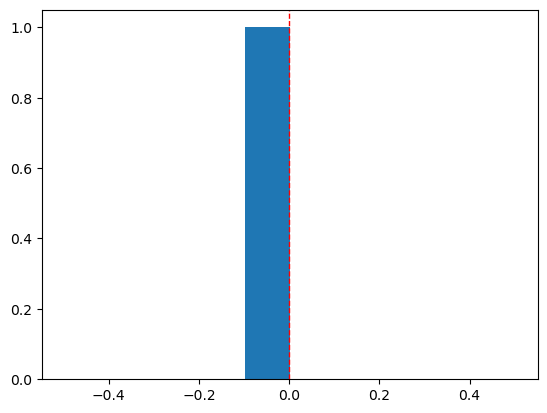

In [56]:
n_iterations = 1
flux = np.zeros(n_iterations)
sigma = np.zeros(n_iterations)
noise_psf = moffat(width, height, 2, 1)
maxlag = 20
for i in tqdm(range(n_iterations)):
    noise = np.random.normal(0, .1, (height, width))
    noise = fftconvolve(noise, noise_psf, mode="same") 
    noisy_image = image+noise
    flux[i], hi = calculate_gaap_flux(noisy_image, image_psf, weight, [(height / 2, width / 2)])
    sigma[i] = estimate_sigma(noise, weight_new, maxlag)
print(np.std(flux), np.nanmean(sigma))
plt.hist(sigma)
plt.axvline(np.std(flux), color='r', linestyle='dashed', linewidth=1)
plt.show()

In [11]:
import numpy as np
from scipy.ndimage import uniform_filter

def find_noise_square(image, box_size=50, margin=3):
    """
    Automatically find a square region with low signal (noise-dominated).
    image: 2D array
    box_size: side of the square region (pixels)
    margin: exclude edges
    threshold: how many sigma above the median to consider as "source"
    returns: (y0, x0, y1, x1) slice indices of best noise square
    """
    img = np.asarray(image, float)
    h, w = img.shape

    # smooth absolute value to find low-variance zones
    local_mean = uniform_filter(img, size=box_size)
    local_var = uniform_filter(img**2, size=box_size) - local_mean**2
    local_std = np.sqrt(np.maximum(local_var, 0))

    # exclude borders
    local_std[:margin, :] = np.inf
    local_std[-margin:, :] = np.inf
    local_std[:, :margin] = np.inf
    local_std[:, -margin:] = np.inf

    # pick minimum std region (least structured)
    cy, cx = np.unravel_index(np.nanargmin(local_std), local_std.shape)

    # ensure square fits inside image
    half = box_size // 2
    y0 = max(0, cy - half)
    x0 = max(0, cx - half)
    y1 = min(h, y0 + box_size)
    x1 = min(w, x0 + box_size)

    return y0, x0, y1, x1


In [5]:
from scipy.ndimage import map_coordinates
def calculate_gaap_flux(image, psf, weight, centers):
    """
    Placeholder function for flux calculation.
    """
    weight_rescale = wiener_deconvolution(weight, psf, 0)
    flux_map = fftconvolve(image, weight_rescale[::-1, ::-1], mode='same')

    centers = np.asarray(centers)
    ys = centers[:, 1]
    xs = centers[:, 0]

    valid = np.isfinite(xs) & np.isfinite(ys)
    measured_F = np.full(len(centers), np.nan, dtype=np.float32)
    measured_F[valid] = map_coordinates(flux_map, [ys[valid], xs[valid]], order=1)

    x_negative = image[image<0].flatten()
    sigma = np.sqrt(np.sum(x_negative ** 2) * np.sum(weight_rescale ** 2) / len(x_negative))

    return measured_F, weight_rescale

In [ ]:
from scipy.optimize import curve_fit
def gaussian_2d(xy, amplitude, x0, y0, sigma_x, sigma_y, offset):
    x, y = xy
    g = offset + amplitude * np.exp(
        -(((x - x0)**2)/(2*sigma_x**2) + ((y - y0)**2)/(2*sigma_y**2))
    )
    return g.ravel()

In [63]:
y = np.arange(noisy_image.shape[0])
x = np.arange(noisy_image.shape[1])
x, y = np.meshgrid(x, y)

# Flatten image and coordinates
xdata = np.vstack((x.ravel(), y.ravel()))
ydata = noisy_image.ravel()

amplitude_guess = np.max(noisy_image)
x0_guess = np.argmax(np.sum(noisy_image, axis=0))
y0_guess = np.argmax(np.sum(noisy_image, axis=1))
sigma_x_guess = noisy_image.shape[1]/4
sigma_y_guess = noisy_image.shape[0]/4
offset_guess = np.min(noisy_image)

initial_guess = [amplitude_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess, offset_guess]

popt, _ = curve_fit(gaussian_2d, xdata, ydata, p0=initial_guess)

amplitude, x0, y0, sigma_x, sigma_y, offset = popt
fwhm_x = 2 * np.sqrt(2 * np.log(2)) * sigma_x
fwhm_y = 2 * np.sqrt(2 * np.log(2)) * sigma_y
print(x0, y0)
print(f"FWHM X: {fwhm_x:.2f} pixels")
print(f"FWHM Y: {fwhm_y:.2f} pixels")
print(np.sqrt(sigma_x ** 2 + sigma_y ** 2))

400.95821943745193 401.2348269291378
FWHM X: 66.87 pixels
FWHM Y: -47.32 pixels
34.78680048435967


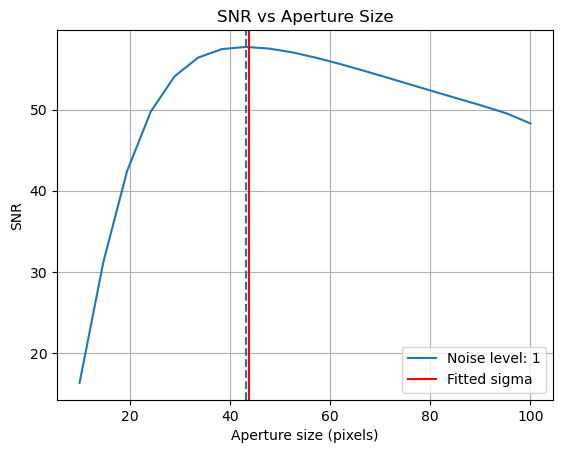

In [23]:
sizes = np.linspace(10, 100, 20)
noise = np.random.normal(0, .1, (height, width))
noise_psf = moffat(width, height, 2, 2)
noise = fftconvolve(noise, noise_psf, mode="same")
noisy_image = image+noise
for noise_levels in [1]:
    snr = np.zeros_like(sizes)
    maxlag = 20
    for i, size in enumerate(sizes):
        weight = gaussian_weight(height, width, height / 2, width / 2, size, size)
        flux, weight_new = calculate_gaap_flux(noisy_image, image_psf, weight, [(height / 2, width / 2)])
        sigma = estimate_sigma(noise * noise_levels, weight_new, maxlag)
        snr[i] = flux / sigma
    plt.plot(sizes, snr, label=f'Noise level: {noise_levels}')
    plt.axvline(sizes[np.argmax(snr)], linestyle='dashed')
plt.axvline(43.89908353603528, color='red', label='Fitted sigma')
plt.xlabel("Aperture size (pixels)")
plt.ylabel("SNR")
plt.title("SNR vs Aperture Size")
plt.grid()
plt.legend()
plt.show()

In [65]:
import numpy as np
from scipy.optimize import curve_fit

def gaussian_2d_rot(coords, A, x0, y0, sx, sy, theta):
    x, y = coords

    cos_t = np.cos(theta)
    sin_t = np.sin(theta)

    x0p = (x - x0) * cos_t + (y - y0) * sin_t
    y0p = -(x - x0) * sin_t + (y - y0) * cos_t

    g = A * np.exp(
        -0.5 * ((x0p / sx)**2 + (y0p / sy)**2)
    )

    return g.ravel()

# example grid
ny, nx = image.shape
y, x = np.mgrid[:ny, :nx]

# initial guesses (important)
p0 = [
    noisy_image.max(),      # A
    nx / 2, ny / 2,   # x0, y0
    2.0, 2.0,         # sx, sy
    0.0
]

popt, pcov = curve_fit(
    gaussian_2d_rot,
    (x, y),
    image.ravel(),
    p0=p0
)


In [66]:
print(popt)

[ 3.36908399e-01  4.00919330e+02  4.00966986e+02  3.20073534e+01
  1.69560967e+01 -9.41905129e+06]


In [31]:
def gaussian_weight_elliptical(
    height,
    width,
    xc=0,
    yc=0,
    sigma_x=1.0,
    sigma_y=1.0,
    theta=0.0
):
    """
    Normalized 2D elliptical Gaussian weight with rotation.

    Parameters
    ----------
    height, width : int
        Output array shape
    xc, yc : float
        Center coordinates (pixel units)
    sigma_x, sigma_y : float
        Gaussian widths along major/minor axes
    theta : float
        Rotation angle in radians (CCW)

    Returns
    -------
    weight : (height, width) ndarray
        Normalized weight map (sum = 1)
    """

    y, x = np.mgrid[:height, :width]

    cos_t = np.cos(theta)
    sin_t = np.sin(theta)

    x_shift = x - xc
    y_shift = y - yc

    x_rot =  x_shift * cos_t + y_shift * sin_t
    y_rot = -x_shift * sin_t + y_shift * cos_t

    weight = np.exp(
        -0.5 * (
            (x_rot / sigma_x) ** 2 +
            (y_rot / sigma_y) ** 2
        )
    )

    weight /= weight.sum()
    return weight

In [67]:
elliptical_weight = gaussian_weight_elliptical(
    height,
    width,
    xc=width / 2,
    yc=height / 2,
    sigma_x=popt[3],
    sigma_y=popt[4],
    theta=popt[5]
)

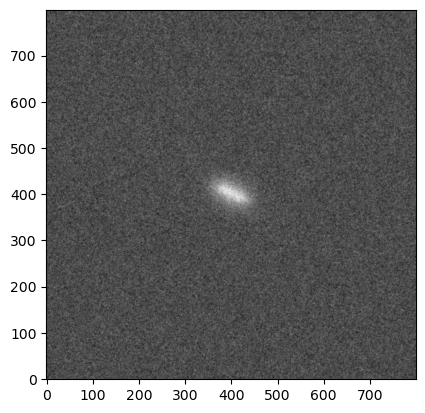

In [57]:
plt.imshow(noisy_image, origin='lower')
plt.show()

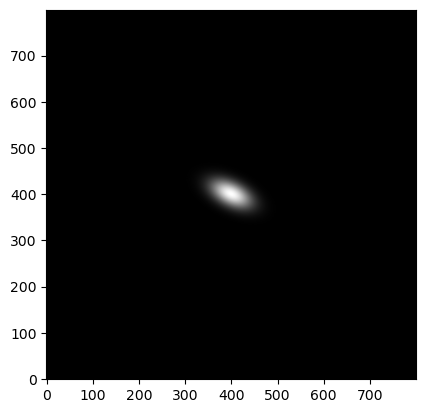

In [61]:
plt.imshow(elliptical_weight)
plt.show()

In [68]:
maxlag = 10
weight = gaussian_weight(height, width, height / 2, width / 2, 34.78680048435967, 34.78680048435967)
flux, weight_new = calculate_gaap_flux(noisy_image, image_psf, weight, [(height / 2, width / 2)])
sigma = estimate_sigma(noise, weight_new, maxlag)
snr_gaussian = flux / sigma
flux, weight_elliptical_new = calculate_gaap_flux(noisy_image, image_psf, elliptical_weight, [(height / 2, width / 2)])
sigma = estimate_sigma(noise, weight_elliptical_new, maxlag)
snr_elliptical = flux / sigma
print(f"SNR Gaussian weight: {snr_gaussian[0]:.2f}")
print(f"SNR Elliptical weight: {snr_elliptical[0]:.2f}")

Deconvolving weight function
Deconvolving weight function
SNR Gaussian weight: 128.27
SNR Elliptical weight: 128.20
